Experiment A2: Activation Patching with Counterfactuals

Same setup as A1
TODO: record adversarial label to test label correctness

https://nnsight.net/notebooks/tutorials/activation_patching/

In [1]:
import nnsight
from nnsight import NNsight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

from robustness import model_utils
from robustness.datasets import CIFAR

import torchvision.transforms as transforms
import torchvision
from PIL import Image

import os
import sys
from tqdm import tqdm

# Add the parent directory to the path to import custom modules
sys.path.append(os.path.abspath(os.path.join('..')))
from models.resnet import ResNet18
from adversarial.utils import load_dataset  



2025-05-19 15:31:39.631014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# load saved model
datapath = '/u/yshi23/distribution-shift/datasets'
model_pth = "/u/yshi23/distribution-shift/adversarial/verify/best_model.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = ResNet18(num_classes=10)
checkpoint = torch.load(model_pth, map_location=device)
state_dict = checkpoint

# Load the modified state dict with strict=False to ignore missing/unexpected keys
model.load_state_dict(checkpoint, strict=False)

print("Model loaded successfully on", device)

Model loaded successfully on cuda:0


In [3]:
def test(model, loader, device: str = "cuda:0"):
    # do some sanity check to ensure typing is correct
    assert isinstance(model, nn.Module)
    assert isinstance(loader, DataLoader)
    # set model to evaluation mode
    model.eval()
    # move model to device
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only expect a single output
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # compute and return accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy on test set is {accuracy}")
    return accuracy


In [4]:
# test the model as a sanity check, on cifar10 testset
_, _, testloader = load_dataset(datapath)

# load cifar10 testset through torchvision
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.25, 0.25, 0.25),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader_orig = DataLoader(trainset, batch_size=64, shuffle=True)
testloader_orig = DataLoader(testset, batch_size=64, shuffle=False)


print("Testing on robustness CIFAR10 testset")
test(model, testloader)

print("Testing on torchvision CIFAR10 testset")
test(model, testloader_orig)

Successfully loaded data loaders
Testing on robustness CIFAR10 testset


100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


Accuracy on test set is 35.56
Testing on torchvision CIFAR10 testset


100%|██████████| 157/157 [00:09<00:00, 15.86it/s]

Accuracy on test set is 87.98


87.98

In [5]:
from torch.utils.data import ConcatDataset

# Concatenate train and test sets to form the baseline dataset
baseline_dataset = ConcatDataset([trainset, testset])
baseline_loader = DataLoader(baseline_dataset, batch_size=64, shuffle=False)
print(f"Baseline loader created with {len(baseline_dataset)} samples.")


Baseline loader created with 60000 samples.


In [6]:
def load_cifar10_image(image_path):
    # Load the image
    img = Image.open(image_path).convert("RGB")

    # Define the transforms that match ResNet18 expectations
    transform = transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),  # Must be before Normalize
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    # Apply transformations
    img_tensor = transform(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)  # Shape: [1, 3, 32, 32]

    return img_tensor


# Usage example
orig_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/natural_image_0.png"
clean_img = load_cifar10_image(orig_path)

low_ep_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/adv_image_small_epsilon_0.png"
low_eps_img = load_cifar10_image(low_ep_path)

high_ep_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/adv_image_large_epsilon_0.png"
high_eps_img = load_cifar10_image(high_ep_path)

In [9]:
def load_cifar10_data(pt_path):
    # Load the CIFAR-10 dataset of generated adversarial paths into a DataLoader
    # paths have data.pt and labels.pt
    data = torch.load(f"{pt_path}/data.pt")
    labels = torch.load(f"{pt_path}/labels.pt")
    dataset = torch.utils.data.TensorDataset(data, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    return dataloader

def load_all_perturbations(pt_folder):
    # Load subfolders starting with "normal" or "l2_normal"
    pt_folder = "/u/yshi23/distribution-shift/adversarial/path_to_save"
    subfolders = [
        f for f in os.scandir(pt_folder)
        if f.is_dir() and (os.path.basename(f.path).startswith("normal") or os.path.basename(f.path).startswith("l2_normal"))
    ]
    dataloader_dict = {}
    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder.path)
        dataloader = load_cifar10_data(subfolder.path)
        # Replace 'l2_normal' with 'l2', then 'normal' with 'linf' in the key
        key_name = subfolder_name.replace("l2_normal", "l2").replace("normal", "linf")
        dataloader_dict[key_name] = dataloader

    # Define the transforms that match ResNet18 expectations
    transform = transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),  # Must be before Normalize
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    dataloader_dict["baseline"] = baseline_loader
    return dataloader_dict

perturbations_dict = load_all_perturbations("/u/yshi23/distribution-shift/adversarial/path_to_save")
print(perturbations_dict.keys())


dict_keys(['linf_low_dataset', 'l2_low_dataset', 'l2_high_dataset', 'linf_high_dataset', 'baseline'])


In [10]:
# Assert that all dataloaders have the same number of samples
baseline_len = len(perturbations_dict["baseline"].dataset)
linf_high_len = len(perturbations_dict["linf_high_dataset"].dataset)
linf_low_len = len(perturbations_dict["linf_low_dataset"].dataset)
l2_high_len = len(perturbations_dict["l2_high_dataset"].dataset)
l2_low_len = len(perturbations_dict["l2_low_dataset"].dataset)

print(f"Baseline dataset length: {baseline_len}")
print(f"Normal high dataset length: {linf_high_len}")
print(f"Normal low dataset length: {linf_low_len}")
print(f"L2 high dataset length: {l2_high_len}")
print(f"L2 low dataset length: {l2_low_len}")

assert baseline_len == linf_low_len == linf_high_len == l2_high_len == l2_low_len, (
    f"Dataset lengths do not match! "
)
print("All dataloaders have the same number of samples.")

Baseline dataset length: 60000
Normal high dataset length: 60000
Normal low dataset length: 60000
L2 high dataset length: 60000
L2 low dataset length: 60000
All dataloaders have the same number of samples.


In [11]:
# baseline labels are indices, but linf_high, linf_low, l2_high, l2_low are logits before softmax
# do a sanity check to ensure that the softmaxed labels for all are the same as the baseline labels and not the same as each other

baseline_loader = perturbations_dict["baseline"]
linf_high_loader = perturbations_dict["linf_high_dataset"]
linf_low_loader = perturbations_dict["linf_low_dataset"]
l2_high_loader = perturbations_dict["l2_high_dataset"]
l2_low_loader = perturbations_dict["l2_low_dataset"]

baseline_labels = []
linf_high_labels = []
linf_low_labels = []
l2_high_labels = []
l2_low_labels = []

# Iterate through batches (assume same order/length)
for (b_data, b_labels), (_, linf_high_logits), (_, linf_low_logits), (_, l2_high_logits), (_, l2_low_logits) in zip(
    baseline_loader, linf_high_loader, linf_low_loader, l2_high_loader, l2_low_loader
):
    # Baseline: labels are indices
    baseline_labels.append(b_labels)
    # linf/l2: logits, need softmax+argmax
    linf_high_pred = torch.argmax(F.softmax(linf_high_logits, dim=1), dim=1)
    linf_low_pred = torch.argmax(F.softmax(linf_low_logits, dim=1), dim=1)
    l2_high_pred = torch.argmax(F.softmax(l2_high_logits, dim=1), dim=1)
    l2_low_pred = torch.argmax(F.softmax(l2_low_logits, dim=1), dim=1)
    linf_high_labels.append(linf_high_pred)
    linf_low_labels.append(linf_low_pred)
    l2_high_labels.append(l2_high_pred)
    l2_low_labels.append(l2_low_pred)

baseline_labels = torch.cat(baseline_labels)
linf_high_labels = torch.cat(linf_high_labels)
linf_low_labels = torch.cat(linf_low_labels)
l2_high_labels = torch.cat(l2_high_labels)
l2_low_labels = torch.cat(l2_low_labels)

print(f"Baseline labels shape: {baseline_labels.shape}")
print(f"Linf high labels shape: {linf_high_labels.shape}")
print(f"Linf low labels shape: {linf_low_labels.shape}")
print(f"L2 high labels shape: {l2_high_labels.shape}")
print(f"L2 low labels shape: {l2_low_labels.shape}")

# Check if each matches baseline
linf_high_matches = linf_high_labels == baseline_labels
linf_low_matches = linf_low_labels == baseline_labels
l2_high_matches = l2_high_labels == baseline_labels
l2_low_matches = l2_low_labels == baseline_labels

# Check if l2 and linf match each other
linf_high_vs_l2_high = linf_high_labels == l2_high_labels
linf_low_vs_l2_low = linf_low_labels == l2_low_labels

print(f"linf_high matches baseline: {linf_high_matches.float().mean().item()*100:.2f}%")
print(f"linf_low matches baseline: {linf_low_matches.float().mean().item()*100:.2f}%")
print(f"l2_high matches baseline: {l2_high_matches.float().mean().item()*100:.2f}%")
print(f"l2_low matches baseline: {l2_low_matches.float().mean().item()*100:.2f}%")
print(f"linf_high matches l2_high: {linf_high_vs_l2_high.float().mean().item()*100:.2f}%")
print(f"linf_low matches l2_low: {linf_low_vs_l2_low.float().mean().item()*100:.2f}%")


Baseline labels shape: torch.Size([60000])
Linf high labels shape: torch.Size([60000])
Linf low labels shape: torch.Size([60000])
L2 high labels shape: torch.Size([60000])
L2 low labels shape: torch.Size([60000])
linf_high matches baseline: 0.03%
linf_low matches baseline: 11.80%
l2_high matches baseline: 24.45%
l2_low matches baseline: 84.89%
linf_high matches l2_high: 17.87%
linf_low matches l2_low: 19.77%


In [12]:
# Get all layer names (keys) from the model's state dictionary
layer_names = list(model.state_dict().keys())

# Print all layer names
print("Model layer names:")
for name in layer_names:
    print(name)

Model layer names:
conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.shortcut.0.weight


In [13]:
nnsight_model = NNsight(model)

In [14]:
import matplotlib.pyplot as plt

LAYER_NAMES = [
    "conv1",
    "layer1",
    "layer2.0.shortcut.0",
    "layer2.0.shortcut.1",
    "layer2",
    "layer3.0.shortcut.0",
    "layer3.0.shortcut.1",
    "layer3",
    "layer4.0.shortcut.0",
    "layer4.0.shortcut.1",
    "layer4",
    "linear",
]


def get_nested_module(model, name):
    """Recursively navigate dot-separated paths including numeric indexes."""
    parts = name.split(".")
    for part in parts:
        if part.isdigit():
            model = model[int(part)]
        else:
            model = getattr(model, part)
    return model


def collect_adversarial_activations(nnsight_model, adversarial_img):
    """Trace and collect activations for each layer from an adversarial image."""
    with nnsight_model.trace(adversarial_img):
        return {
            name: get_nested_module(nnsight_model, name).output.save()
            for name in LAYER_NAMES
        }


def test_adversarial_activations(nnsight_model, clean_img, adv_activations):
    """
    Inject adversarial activations into clean input at each layer and save final output.
    """
    output_results = []

    for name in LAYER_NAMES:
        layer = get_nested_module(nnsight_model, name)
        with nnsight_model.trace(clean_img):
            layer.output = adv_activations[name]
            final_output = nnsight_model.linear.output.save()
        output_results.append({"layer_name": name, "output": final_output})

    return output_results


def get_clean_baseline(nnsight_model, clean_img):
    """Get the output of the model for a clean input."""
    with nnsight_model.trace(clean_img):
        return nnsight_model.linear.output.save()

def get_adv_baseline(nnsight_model, adv_img):
    """Get the output of the model for an adversarial input."""
    with nnsight_model.trace(adv_img):
        return nnsight_model.linear.output.save()

def plot_confidence_difference(
    output_results, clean_baseline, adv_baseline, idx1, idx2, title="Confidence Difference Heatmap"
):
    """
    Plot class confidence differences (idx1 - idx2) with and without adversarial injections.
    """
    x_labels = ["clean base"] + ["adv base"] + [r["layer_name"] for r in output_results]

    def get_diff(logits):
        logits = logits.detach().cpu().numpy()[0]
        return logits[idx1] - logits[idx2]

    differences = [get_diff(clean_baseline)] + [get_diff(adv_baseline)] + [
        get_diff(r["output"]) for r in output_results
    ]

    plt.figure(figsize=(12, 4))
    plt.imshow([differences], cmap="RdBu_r", aspect="auto")
    plt.colorbar(label=f"Confidence Difference (class {idx1} - class {idx2})")
    plt.yticks([])
    plt.xticks(range(len(x_labels)), x_labels, rotation=45)
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()


def analyze_adversarial_effects(nnsight_model, clean_img, adversarial_img):
    """
    Full pipeline: collect adversarial features, inject at each layer, plot effects.
    """
    print("Collecting adversarial activations...")
    adv_activations = collect_adversarial_activations(nnsight_model, adversarial_img)

    print("Getting clean baseline...")
    clean_baseline = get_clean_baseline(nnsight_model, clean_img)

    print("Getting adversarial baseline...")
    adv_baseline = get_adv_baseline(nnsight_model, adversarial_img)

    clean_label = torch.argmax(clean_baseline)
    adv_label = torch.argmax(adv_baseline)
    assert clean_label != adv_label, "Clean and adversarial labels should be different!"

    print(f"Clean label: {clean_label}, Adversarial label: {adv_label}")

    print("Testing adversarial activations at each layer...")
    output_results = test_adversarial_activations(
        nnsight_model, clean_img, adv_activations
    )

    print("Plotting confidence difference...")
    fig = plot_confidence_difference(
        output_results,
        clean_baseline,
        adv_baseline,
        clean_label,
        adv_label,
        title=f"Confidence Gap Between Clean and Adversarial Labels",
    )

    plt.show()

    return {
        "clean_baseline": clean_baseline,
        "adv_baseline": adv_baseline,
        "layer_results": output_results,
        "figure": fig,
    }

def analyze_adversarial_effects_average(nnsight_model, dataloader_clean, dataloader_adv, num_images=100):
    """
    Compute average effects of adversarial patching over the first num_images in each dataloader.
    Returns dict with average clean_baseline, adv_baseline, and average layer_results.
    """
    clean_iter = iter(dataloader_clean)
    adv_iter = iter(dataloader_adv)

    # Storage for results
    clean_baselines = []
    adv_baselines = []
    all_layer_results = []  # List of list of dicts

    for i in range(num_images):
        try:
            clean_img, clean_lab = next(clean_iter)
            adv_img, adv_lab = next(adv_iter)
        except StopIteration:
            break
        # Only use first image in batch for simplicity
        clean_img = clean_img[0:1].cuda() if torch.cuda.is_available() else clean_img[0:1]
        adv_img = adv_img[0:1].cuda() if torch.cuda.is_available() else adv_img[0:1]

        adv_activations = collect_adversarial_activations(nnsight_model, adv_img)
        clean_baseline = get_clean_baseline(nnsight_model, clean_img)
        adv_baseline = get_adv_baseline(nnsight_model, adv_img)
        assert not torch.equal(clean_baseline, adv_baseline), "Clean and adversarial baselines should be different!"
        print(f"Clean label max: {torch.argmax(clean_baseline)}, Adversarial label max: {torch.argmax(adv_baseline)}")
        print(f"clean labels raw: {clean_baseline}, adv labels raw: {adv_baseline}")
        print(f"clean label dataloader: {clean_lab}, adv labels dataloader: {adv_lab}")
        output_results = test_adversarial_activations(nnsight_model, clean_img, adv_activations)

        clean_baselines.append(clean_baseline.detach().cpu())
        adv_baselines.append(adv_baseline.detach().cpu())
        all_layer_results.append([r["output"].detach().cpu() for r in output_results])

    # Stack and average
    clean_baselines = torch.stack(clean_baselines)
    adv_baselines = torch.stack(adv_baselines)
    all_layer_results = torch.stack([torch.stack(x) for x in all_layer_results])  # shape: [num_images, num_layers, ...]
    avg_clean_baseline = clean_baselines.mean(dim=0)
    avg_adv_baseline = adv_baselines.mean(dim=0)
    avg_layer_results = all_layer_results.mean(dim=0)  # shape: [num_layers, ...]

    return {
        "avg_clean_baseline": avg_clean_baseline,
        "avg_adv_baseline": avg_adv_baseline,
        "avg_layer_results": avg_layer_results,
    }

def run_average_adversarial_comparisons(nnsight_model, perturbations_dict, num_images=100):
    """
    Run average adversarial effects for (baseline, low_eps), (baseline, high_eps), (low_eps, high_eps).
    Assumes keys: 'baseline', 'normal_low_dataset', 'normal_high_dataset' in perturbations_dict.
    """
    results = {}
    # Baseline vs low eps
    results['baseline_vs_low'] = analyze_adversarial_effects_average(
        nnsight_model,
        perturbations_dict['baseline'],
        perturbations_dict['normal_low_dataset'],
        num_images=num_images
    )
    # Baseline vs high eps
    results['baseline_vs_high'] = analyze_adversarial_effects_average(
        nnsight_model,
        perturbations_dict['baseline'],
        perturbations_dict['normal_high_dataset'],
        num_images=num_images
    )
    # Low vs high eps
    results['low_vs_high'] = analyze_adversarial_effects_average(
        nnsight_model,
        perturbations_dict['normal_low_dataset'],
        perturbations_dict['normal_high_dataset'],
        num_images=num_images
    )
    return results

def plot_average_confidence_differences(avg_results, idx1=None, idx2=None):
    """
    Plot stacked confidence difference heatmaps for the three combinations of average adversarial effects.
    If idx1 and idx2 are None, use the most common label in the first 100 images of each dataloader as the class indices.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    combinations = [
        ("baseline_vs_low", "Baseline vs Low Eps"),
        ("baseline_vs_high", "Baseline vs High Eps"),
        ("low_vs_high", "Low Eps vs High Eps"),
    ]

    # --- Fix: get correct dummy activations for layer_names ---
    # Use a real input to get the output shapes for each layer
    dummy_img = torch.zeros(1, 3, 32, 32)
    if torch.cuda.is_available():
        dummy_img = dummy_img.cuda()
    with nnsight_model.trace(dummy_img):
        proxies = {name: get_nested_module(nnsight_model, name).output.save() for name in LAYER_NAMES}
    # Now, get the shapes from the .value attribute
    layer_output_shapes = {name: proxy.value.shape for name, proxy in proxies.items()}
    # Create dummy activations with correct shapes and device
    correct_shape_activations = {name: torch.zeros(shape, device=dummy_img.device) for name, shape in layer_output_shapes.items()}
    # Get layer names for x-axis
    layer_names = ["clean base", "adv base"] + [r["layer_name"] for r in test_adversarial_activations(nnsight_model, torch.zeros(1,3,32,32, device=dummy_img.device), correct_shape_activations)]
    fig, axes = plt.subplots(len(combinations), 1, figsize=(14, 3 * len(combinations)), sharey=True)
    if len(combinations) == 1:
        axes = [axes]
    for ax, (key, title) in zip(axes, combinations):
        res = avg_results[key]
        avg_clean = res["avg_clean_baseline"]
        avg_adv = res["avg_adv_baseline"]
        avg_layers = res["avg_layer_results"]
        # If idx1/idx2 not provided, use the most common label in the first 100 images of each dataloader
        if idx1 is None or idx2 is None:
            # Use the argmax of the average clean and adv baseline logits
            idx1_ = int(torch.argmax(avg_clean).item())
            idx2_ = int(torch.argmax(avg_adv).item())
        else:
            idx1_ = idx1
            idx2_ = idx2
        def get_diff(logits):
            logits = logits.detach().cpu().numpy()[0] if logits.ndim == 2 else logits.detach().cpu().numpy()
            return logits[idx1_] - logits[idx2_]
        differences = [get_diff(avg_clean), get_diff(avg_adv)]
        for i in range(avg_layers.shape[0]):
            differences.append(get_diff(avg_layers[i]))
        im = ax.imshow([differences], cmap="RdBu_r", aspect="auto")
        ax.set_yticks([])
        ax.set_xticks(range(len(layer_names)))
        ax.set_xticklabels(layer_names, rotation=45)
        ax.set_title(f"{title}: Confidence Difference (class {idx1_} - class {idx2_})")
        fig.colorbar(im, ax=ax, orientation='vertical', label=f"Confidence Difference (class {idx1_} - class {idx2_})")
    plt.tight_layout()
    plt.show()
    return fig

Getting clean baseline...
Getting adversarial baseline...
Clean label: 2, Adversarial label: 1
Testing adversarial activations at each layer...
Plotting confidence difference...


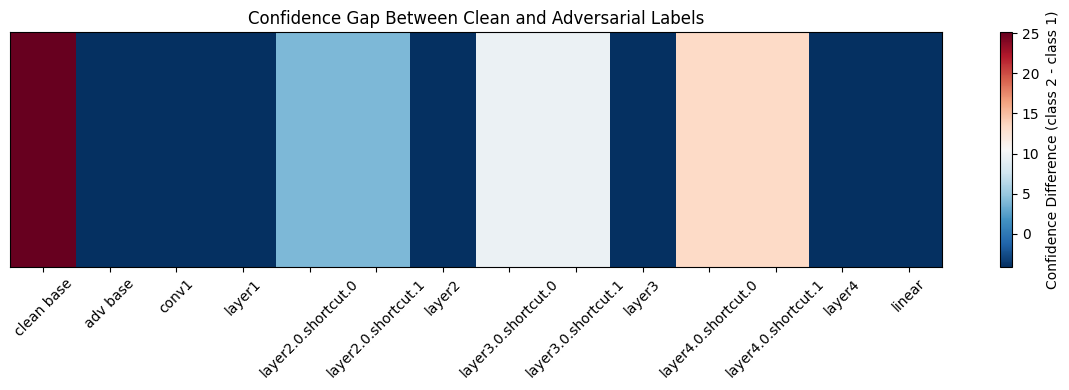

{'clean_baseline': tensor([[-0.8873, -6.6468, 18.4463,  1.0133,  3.9817,  1.1374,  1.1657, -3.9281,
          -7.1036, -6.1963]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'adv_baseline': tensor([[-0.3120,  5.3881,  1.2758,  1.9173, -1.3316, -2.5145,  4.9557, -4.8704,
          -2.7944, -1.6189]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'layer_results': [{'layer_name': 'conv1',
   'output': tensor([[-0.3120,  5.3881,  1.2758,  1.9173, -1.3316, -2.5145,  4.9557, -4.8704,
            -2.7944, -1.6189]], device='cuda:0', grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer1',
   'output': tensor([[-0.3120,  5.3881,  1.2758,  1.9173, -1.3316, -2.5145,  4.9557, -4.8704,
            -2.7944, -1.6189]], device='cuda:0', grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer2.0.shortcut.0',
   'output': tensor([[-1.3973, -1.3591,  2.6105,  1.0677,  2.7707, -1.0862, 12.9163, -6.9195,
            -5.7791, -2.9492]], device='cuda:0', grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer2.0.shor

In [17]:
# labels for base, low, high: 2, 4, 6 (auto, deer, frog)
analyze_adversarial_effects(
    nnsight_model,
    clean_img,
    high_eps_img,
)

In [10]:
# alternative signal:
# First trace
with nnsight_model.trace(clean_img) as tracer:
    clean_out = nnsight_model.linear.output.save() # just care about confidence / probs 

with nnsight_model.trace(high_eps_img) as tracer:
    conv1_out = nnsight_model.conv1.output.save()
    layer1_out = nnsight_model.layer1.output.save()
    layer2_out = nnsight_model.layer2.output.save()
    layer3_out = nnsight_model.layer3.output.save()
    layer4_out = nnsight_model.layer4.output.save()

#  patching loop
# loop through captured high eps outputs, patch in at respective time, take difference between clean_out and patch_out(clean_img) 

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def _save_main_layers(model):
    return {
        "conv1": model.conv1.output.save(),
        "bn1": model.bn1.output.save(),
        "layer1": model.layer1.output.save(),
        "layer2": model.layer2.output.save(),
        "layer3": model.layer3.output.save(),
        "layer4": model.layer4.output.save(),
        "linear": model.linear.output.save(),
    }


def _save_block_outputs(layer, prefix):
    return {f"{prefix}.block{i}": block.output.save() for i, block in enumerate(layer)}


def _compute_diffs(clean_act, adv_act):
    return {
        "mean": torch.mean(torch.abs(adv_act - clean_act)).item(),
        "max": torch.max(torch.abs(adv_act - clean_act)).item(),
    }


def visualize_activation_differences(model, clean_img, adv_img):
    """
    Visualize differences in activations between clean and adversarial images
    across all layers of a ResNet model.
    """
    diffs = {}

    # Trace clean image
    with model.trace(clean_img):
        clean_main = _save_main_layers(model)
        clean_blocks = {
            **_save_block_outputs(model.layer1, "layer1"),
            **_save_block_outputs(model.layer2, "layer2"),
            **_save_block_outputs(model.layer3, "layer3"),
            **_save_block_outputs(model.layer4, "layer4"),
        }

    # Trace adversarial image
    with model.trace(adv_img):
        adv_main = _save_main_layers(model)
        adv_blocks = {
            **_save_block_outputs(model.layer1, "layer1"),
            **_save_block_outputs(model.layer2, "layer2"),
            **_save_block_outputs(model.layer3, "layer3"),
            **_save_block_outputs(model.layer4, "layer4"),
        }

    # Compute diffs for main layers
    for name in clean_main:
        diffs[name] = _compute_diffs(clean_main[name], adv_main[name])

    # Compute diffs for residual blocks
    for name in clean_blocks:
        diffs[name] = _compute_diffs(clean_blocks[name], adv_blocks[name])

    # Create a DataFrame for plotting
    df = pd.DataFrame.from_dict(diffs, orient="index").reset_index()
    df.columns = ["Layer", "Mean Absolute Difference", "Max Absolute Difference"]

    # Sorting logic based on hierarchical naming
    def get_sort_index(layer_name):
        parts = layer_name.split(".")
        if layer_name.startswith("conv1"):
            return 0
        elif layer_name.startswith("bn1"):
            return 1
        elif layer_name.startswith("relu"):
            return 2
        elif layer_name.startswith("maxpool"):
            return 3
        elif "layer" in parts[0]:
            layer_num = int(parts[0][-1])
            block_num = int(parts[1][-1]) if len(parts) > 1 else -1
            return 4 + layer_num * 10 + (block_num + 1 if block_num >= 0 else 0)
        elif layer_name.startswith("avgpool"):
            return 100
        elif layer_name.startswith("linear"):
            return 101
        return 999  # fallback

    df["SortIdx"] = df["Layer"].apply(get_sort_index)
    df = df.sort_values("SortIdx")

    # Plot
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    sns.barplot(x="Layer", y="Mean Absolute Difference", data=df)
    plt.xticks(rotation=90)
    plt.title(
        "Mean Absolute Activation Differences Between Clean and Adversarial Images"
    )

    plt.subplot(2, 1, 2)
    sns.barplot(x="Layer", y="Max Absolute Difference", data=df)
    plt.xticks(rotation=90)
    plt.title(
        "Maximum Absolute Activation Differences Between Clean and Adversarial Images"
    )

    plt.tight_layout()
    plt.savefig("activation_differences.png")
    plt.show()

    return df

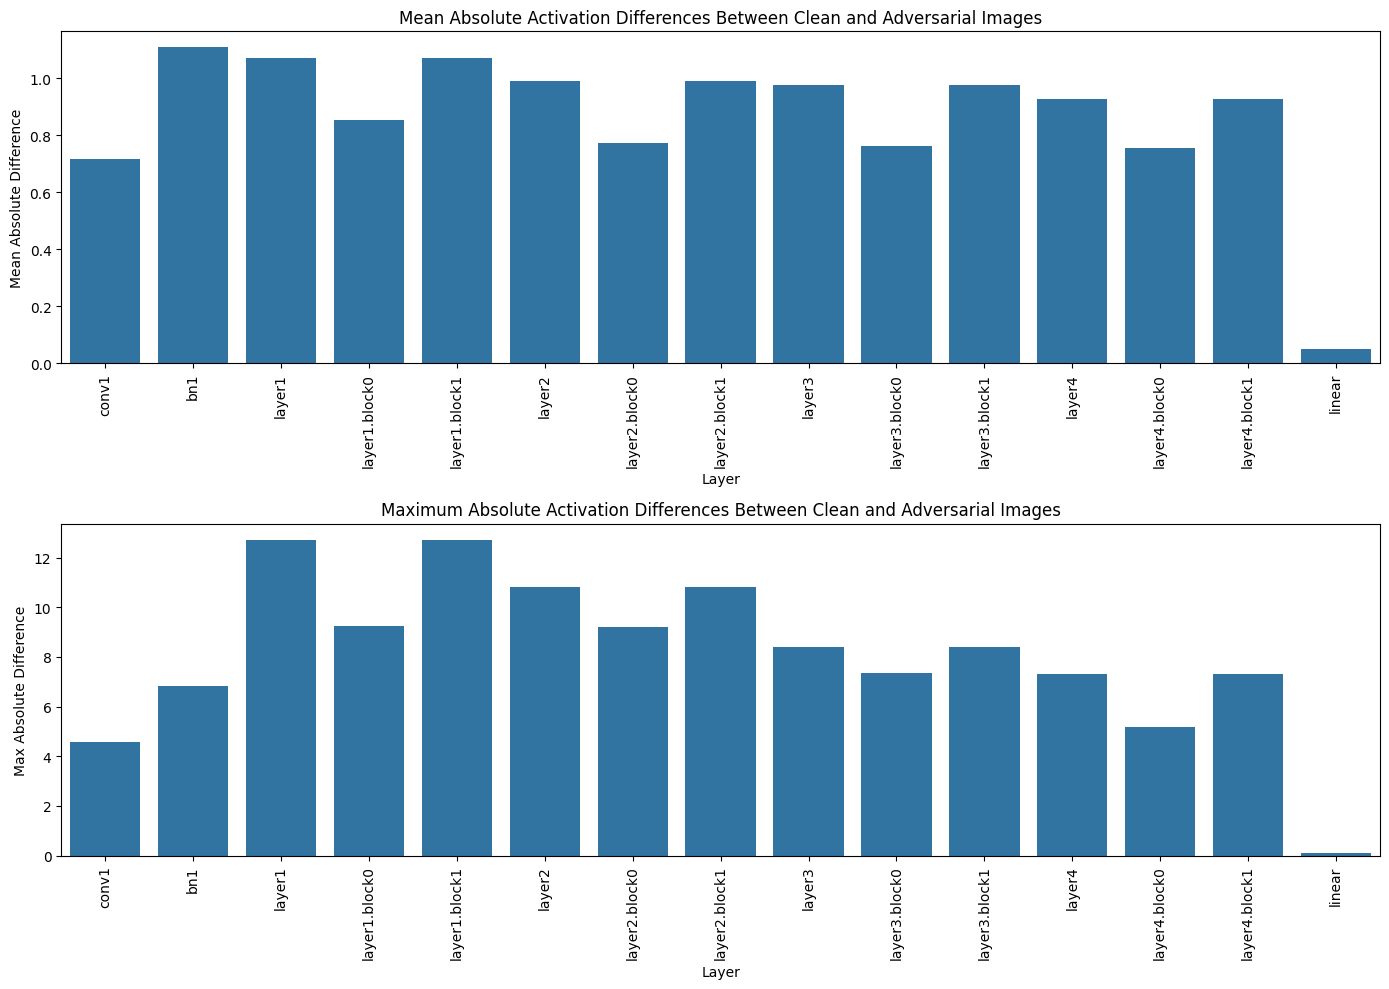

,Layer,Mean Absolute Difference,Max Absolute Difference,SortIdx
0,conv1,0.718119,4.569898,0
1,bn1,1.109219,6.820585,1
2,layer1,1.071224,12.724138,14
7,layer1.block0,0.852682,9.256755,15
8,layer1.block1,1.071224,12.724138,16
3,layer2,0.991933,10.808463,24
9,layer2.block0,0.771806,9.201981,25
10,layer2.block1,0.991933,10.808463,26
4,layer3,0.974906,8.397552,34
11,layer3.block0,0.763218,7.359338,35


In [ ]:
visualize_activation_differences(nnsight_model, clean_img, high_eps_img)

In [17]:
# Get all valid module (layer) names for patching (exclude parameters/buffers)
module_names = [name for name, module in model.named_modules() if name]
print("Valid module names for patching:")
for name in module_names:
    print(name)


def compute_average_confidence_drop(
    nnsight_model, perturbations_dict, scenario="linf_high", num_images=100
):
    """
    Computes the average confidence drop for a given scenario.
    scenario: one of "linf_high", "linf_low", "l2_high", "l2_low"
    Returns a dict: {layer_name: average confidence drop}
    """
    # Map scenario to dataloader keys
    scenario_map = {
        "linf_high": ("baseline", "linf_high_dataset"),
        "linf_low": ("baseline", "linf_low_dataset"),
        "l2_high": ("baseline", "l2_high_dataset"),
        "l2_low": ("baseline", "l2_low_dataset"),
        "linf_low_vs_high": ("linf_low_dataset", "linf_high_dataset"),
        "l2_low_vs_high": ("l2_low_dataset", "l2_high_dataset"),
    }
    if scenario not in scenario_map:
        raise ValueError(f"Unknown scenario: {scenario}")

    loader_clean = perturbations_dict[scenario_map[scenario][0]]
    loader_adv = perturbations_dict[scenario_map[scenario][1]]

    LAYER_NAMES = module_names  # Use only valid module names

    def get_nested_module(model, name):
        parts = name.split(".")
        for part in parts:
            if part.isdigit():
                model = model[int(part)]
            else:
                model = getattr(model, part)
        return model

    clean_iter = iter(loader_clean)
    adv_iter = iter(loader_adv)
    confidence_drops = {name: [] for name in LAYER_NAMES}

    for i in range(num_images):
        try:
            clean_img, _ = next(clean_iter)
            adv_img, _ = next(adv_iter)
        except StopIteration:
            break
        clean_img = (
            clean_img[0:1].cuda() if torch.cuda.is_available() else clean_img[0:1]
        )
        adv_img = adv_img[0:1].cuda() if torch.cuda.is_available() else adv_img[0:1]

        # Get clean logits
        with nnsight_model.trace(clean_img):
            clean_logits_proxy = nnsight_model.linear.output.save()
        clean_logits = clean_logits_proxy.detach().cpu()

        # Get adv activations and extract .value (or direct tensor)
        with nnsight_model.trace(adv_img):
            adv_activations_proxy_dict = {
                name: get_nested_module(nnsight_model, name).output.save()
                for name in LAYER_NAMES
            }

        adv_activations = {}
        for k, v_proxy in adv_activations_proxy_dict.items():
            try:
                adv_activations[k] = v_proxy.value.detach()
            except AttributeError:
                adv_activations[k] = v_proxy.detach()

        clean_label = torch.argmax(clean_logits, dim=1).item()

        # For each layer, patch in adv activation and get patched logits
        for name in LAYER_NAMES:
            module_to_patch = get_nested_module(nnsight_model, name)
            with nnsight_model.trace(clean_img):
                module_to_patch.output = adv_activations[name]
                patched_logits_proxy = nnsight_model.linear.output.save()
            patched_logits = patched_logits_proxy.detach().cpu()

            drop = (
                clean_logits[0, clean_label] - patched_logits[0, clean_label]
            ).item()
            confidence_drops[name].append(drop)

    # Compute average drop per layer
    avg_confidence_drop = {
        name: float(np.mean(confidence_drops[name])) for name in LAYER_NAMES
    }
    return avg_confidence_drop



# # Example usage:
# avg_drop = compute_average_confidence_drop(
#     nnsight_model,
#     perturbations_dict["baseline"],
#     perturbations_dict["normal_high_dataset"],
#     num_images=10000,
# )


Valid module names for patching:
conv1
bn1
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.shortcut
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.shortcut
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.shortcut
layer2.0.shortcut.0
layer2.0.shortcut.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.shortcut
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.shortcut
layer3.0.shortcut.0
layer3.0.shortcut.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.conv2
layer3.1.bn2
layer3.1.shortcut
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.conv2
layer4.0.bn2
layer4.0.shortcut
layer4.0.shortcut.0
layer4.0.shortcut.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.conv2
layer4.1.bn2
layer4.1.shortcut
linear


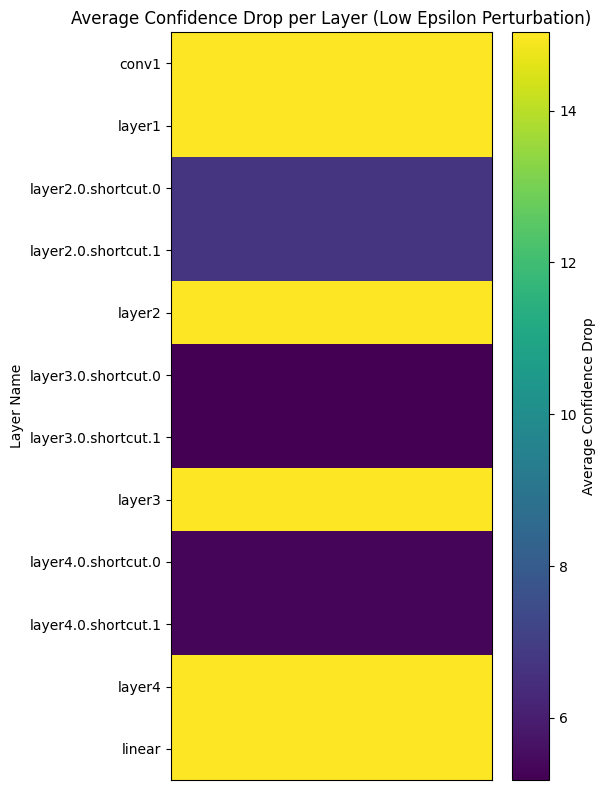

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming average_drops_low_eps is available from the previous cell execution
# If not, you might need to re-run the cell that computes it or copy the dictionary here.

layer_names_plot = list(avg_drop.keys())
avg_drops_plot = list(avg_drop.values())

# Convert to a numpy array and reshape for heatmap (Nx1 for vertical)
heatmap_data = np.array(avg_drops_plot).reshape(-1, 1)

plt.figure(figsize=(6, 8)) # Adjust size as needed
plt.imshow(heatmap_data, cmap='viridis', aspect='auto') # 'viridis', 'coolwarm', 'RdBu_r' are good colormap options

plt.yticks(ticks=np.arange(len(layer_names_plot)), labels=layer_names_plot)
plt.xticks([]) # No x-ticks needed for a vertical bar-like heatmap

plt.colorbar(label='Average Confidence Drop')
plt.title('Average Confidence Drop per Layer (Low Epsilon Perturbation)')
plt.ylabel('Layer Name')
plt.tight_layout()
plt.show()

# Optionally, if you also computed average_drops_high_eps:
# layer_names_high = list(average_drops_high_eps.keys())
# avg_drops_high = list(average_drops_high_eps.values())
# heatmap_data_high = np.array(avg_drops_high).reshape(-1, 1)

# plt.figure(figsize=(6, 8))
# plt.imshow(heatmap_data_high, cmap='viridis', aspect='auto')
# plt.yticks(ticks=np.arange(len(layer_names_high)), labels=layer_names_high)
# plt.xticks([])
# plt.colorbar(label='Average Confidence Drop')
# plt.title('Average Confidence Drop per Layer (High Epsilon Perturbation)')
# plt.ylabel('Layer Name')
# plt.tight_layout()
# plt.show()


Computing: Clean Baseline vs. Linf Low Eps Perturbation...
Computing: Clean Baseline vs. Linf High Eps Perturbation...
Computing: Clean Baseline vs. Linf High Eps Perturbation...
Computing: Linf Low Eps vs. Linf High Eps Perturbation...
Computing: Linf Low Eps vs. Linf High Eps Perturbation...
Computing: Clean Baseline vs. L2 Low Eps Perturbation...
Computing: Clean Baseline vs. L2 Low Eps Perturbation...
Computing: Clean Baseline vs. L2 High Eps Perturbation...
Computing: Clean Baseline vs. L2 High Eps Perturbation...
Computing: L2 Low Eps vs. L2 High Eps Perturbation...
Computing: L2 Low Eps vs. L2 High Eps Perturbation...


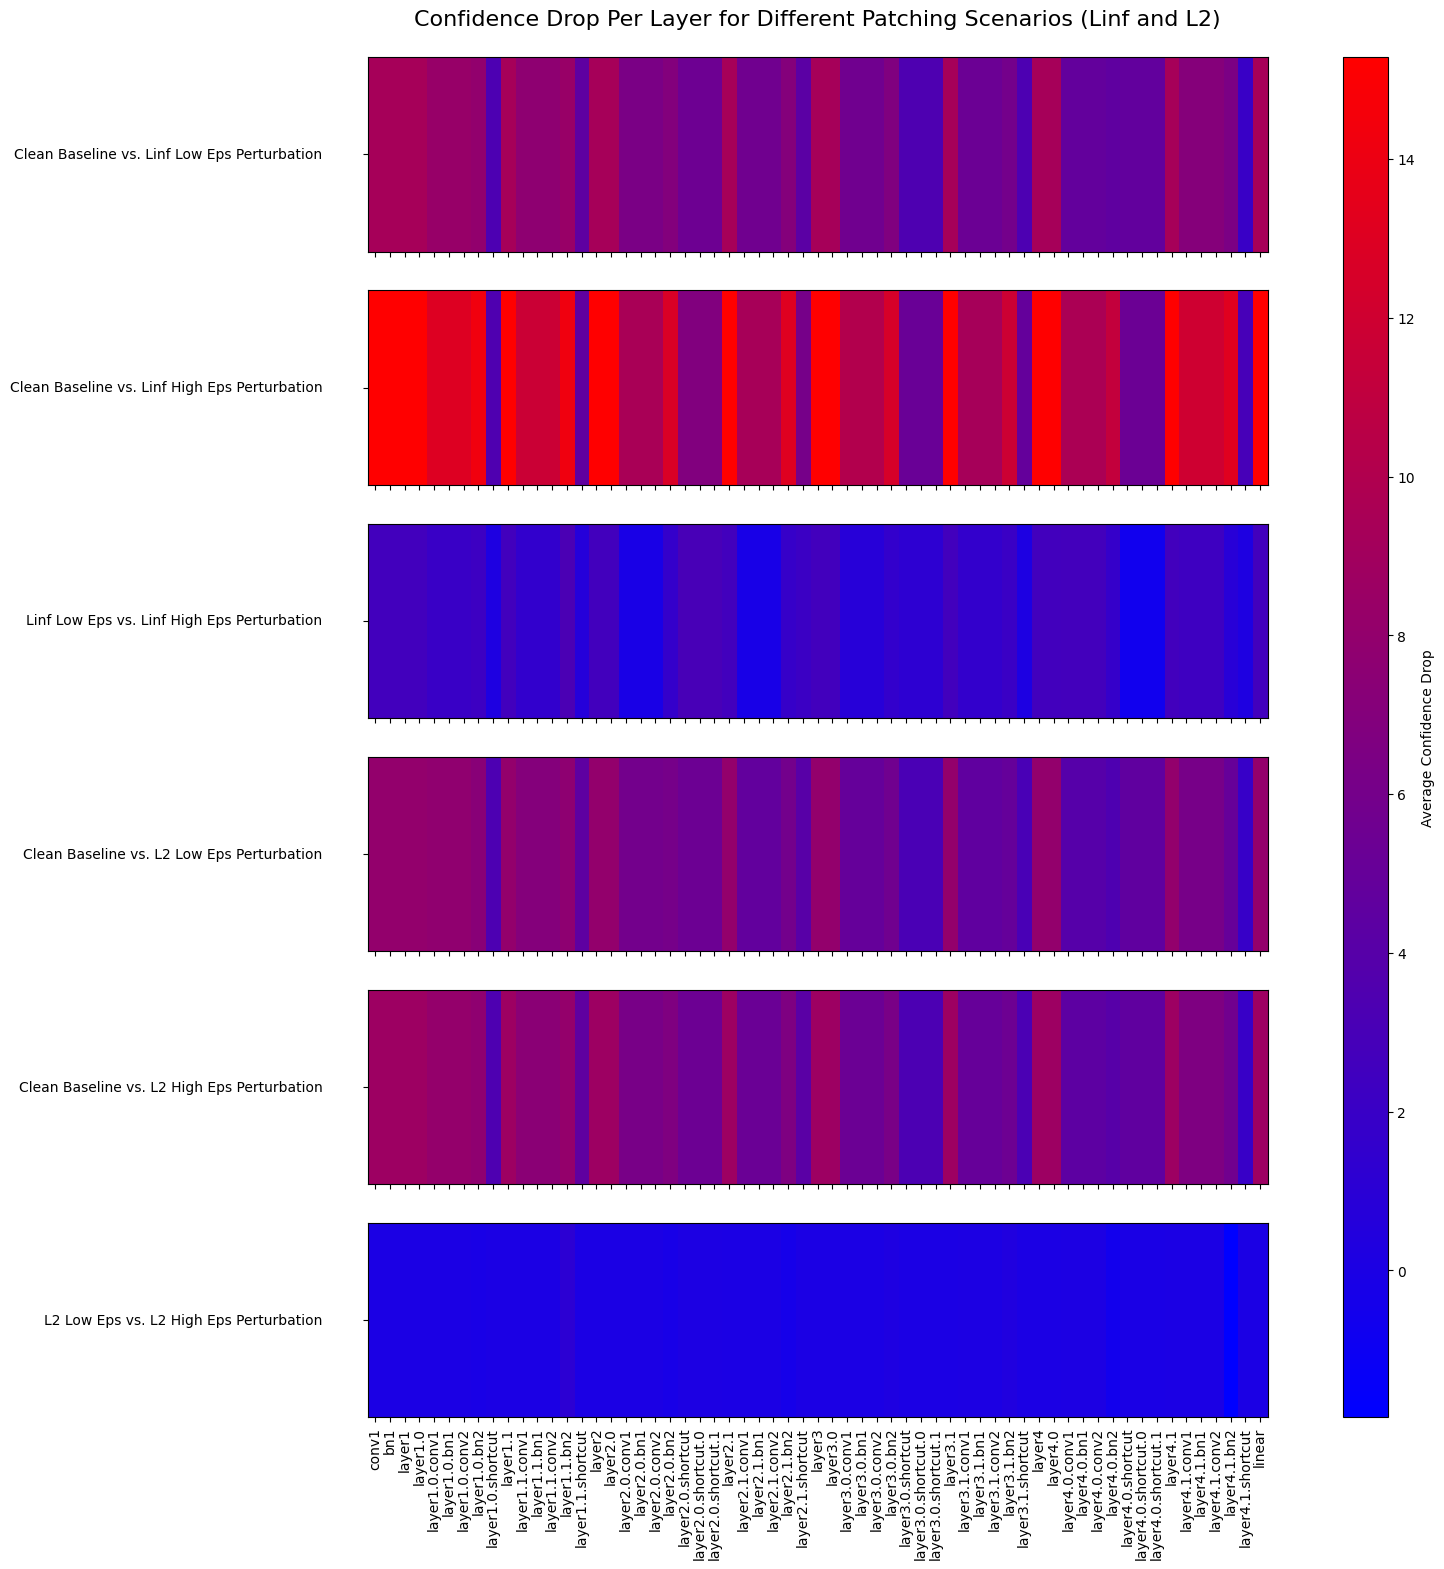

In [18]:
def plot_stacked_confidence_drop_heatmaps(
    nnsight_model, perturbations_dict, num_images=10
):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap

    # Define scenarios and titles for plotting
    scenarios = [
        ("linf_low", "Clean Baseline vs. Linf Low Eps Perturbation"),
        ("linf_high", "Clean Baseline vs. Linf High Eps Perturbation"),
        ("linf_low_vs_high", "Linf Low Eps vs. Linf High Eps Perturbation"),
        ("l2_low", "Clean Baseline vs. L2 Low Eps Perturbation"),
        ("l2_high", "Clean Baseline vs. L2 High Eps Perturbation"),
        ("l2_low_vs_high", "L2 Low Eps vs. L2 High Eps Perturbation"),
    ]

    plot_data = []
    titles = []
    for scenario, title in scenarios:
        print(f"Computing: {title}...")
        try:
            results = compute_average_confidence_drop(
                nnsight_model, perturbations_dict, scenario=scenario, num_images=num_images
            )
        except Exception as e:
            print(f"Error in scenario {scenario}: {e}")
            results = None
        plot_data.append(results)
        titles.append(title)

    # Check for at least one valid result
    if not any(plot_data):
        print("Error: No data to plot after computing all scenarios.")
        return

    # Use the first non-empty result to get layer names
    for res in plot_data:
        if res:
            layer_names = list(res.keys())
            break

    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 16), sharex=True)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    all_values = []
    for res_dict in plot_data:
        if res_dict:
            all_values.extend(res_dict.values())

    if not all_values:
        print("Error: No data to plot after computing all scenarios.")
        return

    vmin = min(all_values)
    vmax = max(all_values)
    if vmin == vmax:
        vmin -= 0.1
        vmax += 0.1

    # Define a blue-purple-red colormap
    custom_cmap = LinearSegmentedColormap.from_list(
        "blue_purple_red", ["blue", "purple", "red"]
    )

    for i, ax in enumerate(axes):
        current_drops_dict = plot_data[i]
        current_title = titles[i]

        if not current_drops_dict:
            print(f"Warning: No data for scenario: {current_title}")
            ax.text(
                0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes
            )
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        heatmap_values = np.array(list(current_drops_dict.values())).reshape(1, -1)

        im = ax.imshow(
            heatmap_values, cmap=custom_cmap, aspect="auto", vmin=vmin, vmax=vmax
        )

        ax.set_yticks([0])
        ax.text(
            -0.05,
            0.5,
            current_title,
            rotation=0,
            va="center",
            ha="right",
            transform=ax.transAxes,
            fontsize=10,
        )
        ax.set_yticklabels([])

        ax.set_xticks(np.arange(len(layer_names)))
        if i == len(axes) - 1:
            ax.set_xticklabels(
                layer_names, rotation=90, ha="center"
            )  # Rotate x-axis labels vertically
        else:
            ax.set_xticklabels([])

    fig.subplots_adjust(left=0.2, right=0.80, top=0.95, bottom=0.10)

    cbar_ax = fig.add_axes([0.85, 0.10, 0.03, 0.85])
    fig.colorbar(
        im, cax=cbar_ax, label="Average Confidence Drop", orientation="vertical"
    )

    plt.suptitle(
        "Confidence Drop Per Layer for Different Patching Scenarios (Linf and L2)", fontsize=16
    )
    plt.show()

# Call the function
plot_stacked_confidence_drop_heatmaps(nnsight_model, perturbations_dict, num_images=10000)